In [1]:
import pandas as pd
import torch
import sys
import pickle
sys.path.append("../")
from utils import load_and_preprocess_data, evaluate, metrics, plot_results
from agents import EnhancedDQNAgent
from environments import EnhancedTradingEnvironment

Load test data

In [ ]:
window_size = 180
initial_balance = 10000 # USD
time_cycle = '5m'

# Load the scaler
with open('eth_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print('Loaded existing scaler')

# Load test data
data_array, _, _ = load_and_preprocess_data(window_size=window_size, time_cycle=time_cycle,filepath='C:\\Andrey\\Kakua_Projets\\Trading\\Bot_RL_v1\\Datasets\\historical_01-12-2024_to_01-05-2025_5m_ETHUSDT.csv', scaler=scaler)

# --- Data splitting test data only ---
train_size = int(0.8 * len(data_array))
test_data = data_array[train_size:]

# --- All the data is used for testing ---
#test_data = data_array

print(f"\nData division:")
print(f"Total: {len(data_array)}")
print(f"Evaluation: {len(test_data)}")

Saved new scaler

Data division:
Total: 43201
Evaluation: 8641


Create agent and load trained model

In [ ]:
# Initial configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_env = EnhancedTradingEnvironment(test_data, window_size, time_cycle, scaler)
state_size = test_env.state_size
action_size = test_env.action_space
save_path = 'best_trading_model.pth'

# Initialize agent
agent = EnhancedDQNAgent(state_size, action_size, time_cycle, device)

# Load model 
agent, best_score,episode, mean_fold_results, std_fold_results, fold_results, train_rewards = agent.load_model(save_path)

✅ Model loaded successfully with hyperparameters:
γ=0.995, lr=0.0005, batch=128
| ε: 0.0499 | Average Fold results: 0.42% | Best Score: 10.24% |


In [4]:
print("\nLoaded Hyperparameters:")
print(f"• Learning rate (lr): {agent.hyperparams['lr']}")
print(f"• Discount factor (gamma): {agent.hyperparams['gamma']}")
print(f"• Batch size: {agent.hyperparams['batch_size']}")
print(f"• Current epsilon: {agent.epsilon}")



Loaded Hyperparameters:
• Learning rate (lr): 0.0005
• Discount factor (gamma): 0.995
• Batch size: 128
• Current epsilon: 0.04993675381238609


In [ ]:
# --- Final Evaluation ---
print("\nEvaluating on test set...")
test_return, portfolio_history, price_history, actions_history = evaluate(
    agent, test_env, scaler, initial_balance, time_cycle = time_cycle
)


Evaluating on test set...


Metricas

In [ ]:
# Final results and metrics
metrics(portfolio_history, test_return, price_history, actions_history, initial_balance, mean_fold_results, std_fold_results, time_cycle)


--- Final Results ---
CV Performance: 0.42% ± 6.96
Initial Value: $10,000.00
Final Value: $11,091.49
Test Performance (%): 10.91%
Buy & Hold Return: -5.30%
Sharpe Ratio: 3.33
Max Drawdown: $614.58 (6.15%)
Actions: Buy=7.0%, Sell=83.2%, Hold=9.9%


Gráficos

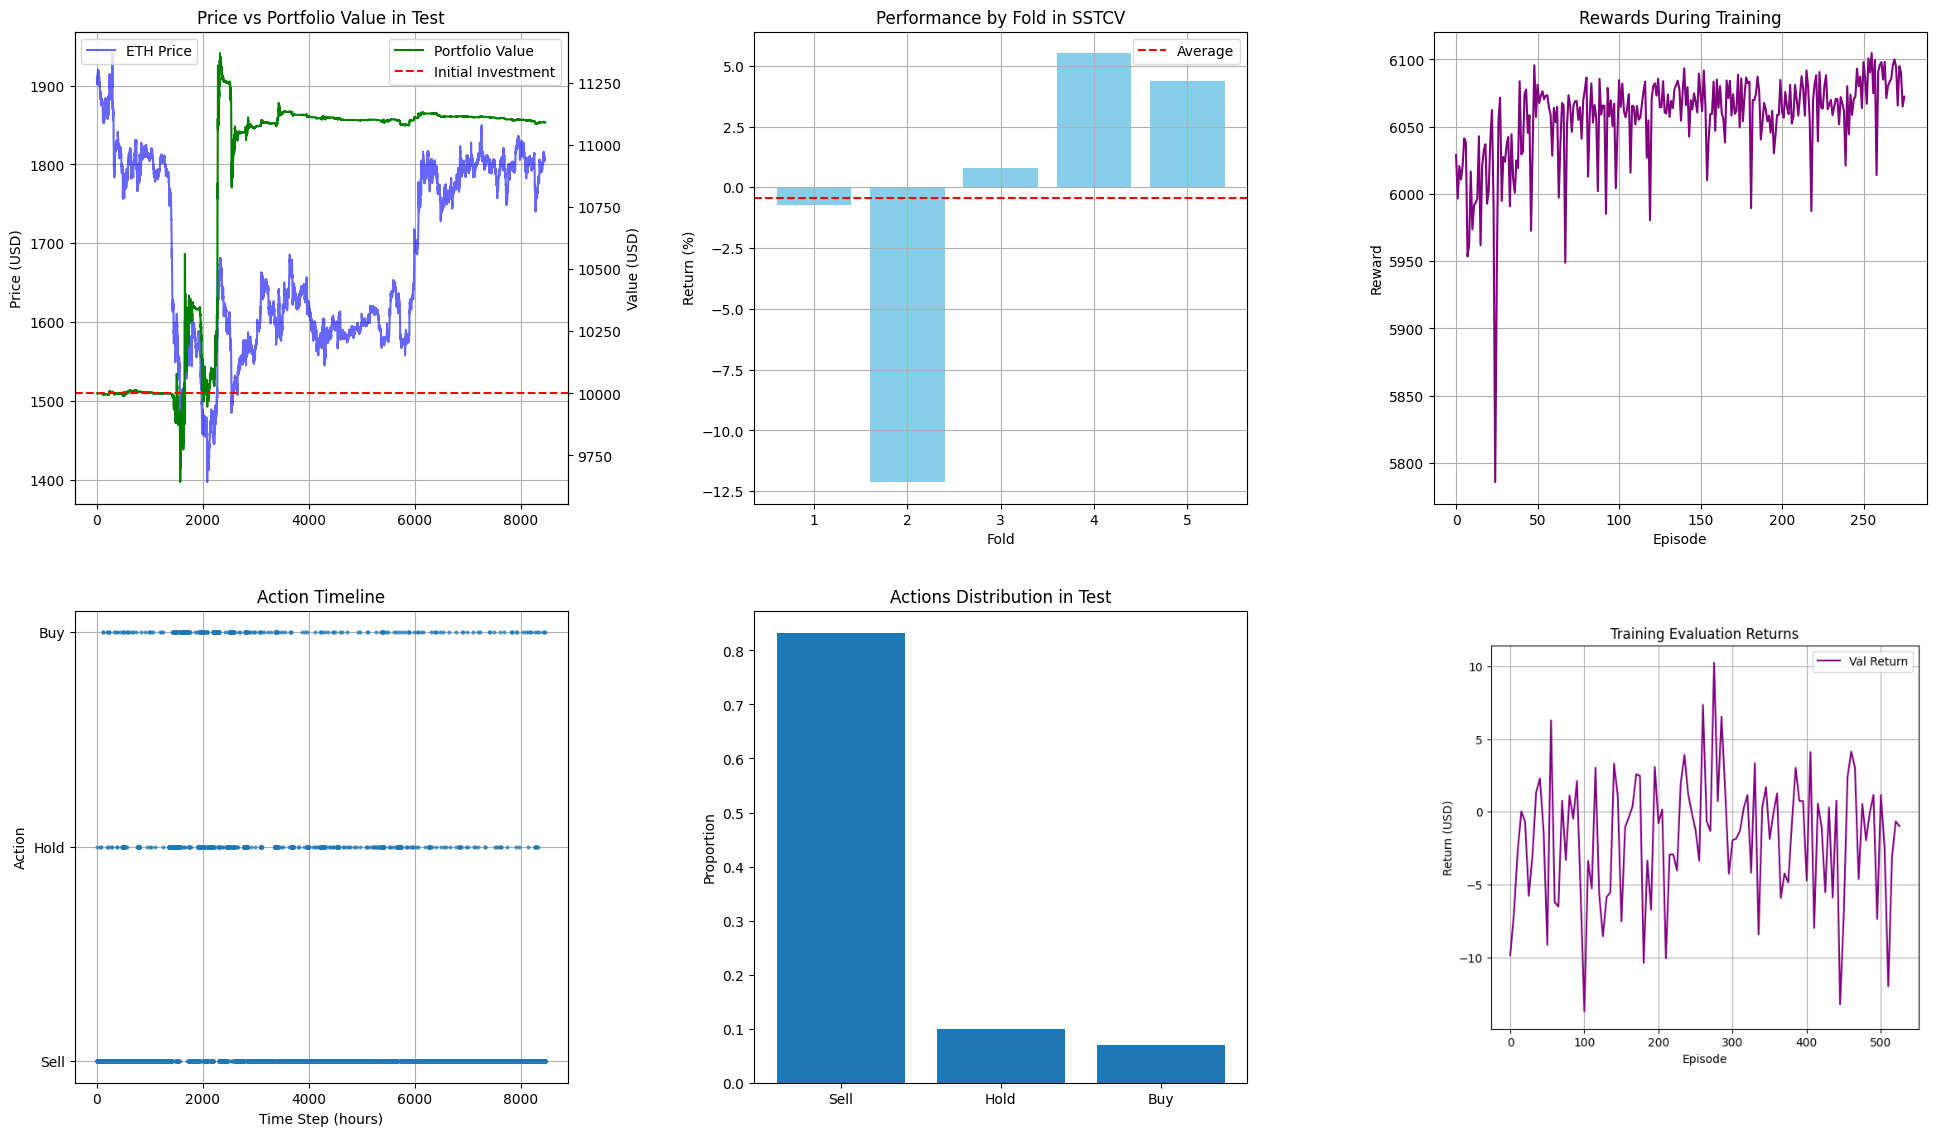

In [ ]:
# Results visualization
test_results = {
        'final_return': test_return,
        'portfolio_history': portfolio_history,
        'price_history': price_history,
        'actions_dist': pd.Series(actions_history).value_counts(normalize=True).to_dict()
    }

plot_results(
    fold_results=fold_results,  
    train_rewards=train_rewards,
    initial_balance=initial_balance,
    actions_history=actions_history,
    test_results=test_results,
    time_cycle=time_cycle,
)